In [1]:
import pandas as pd
import numpy as np
from pygam import GAM, s, l, LogisticGAM
import matplotlib.pyplot as plt
from pandas import Series
from pandas.tools.plotting import lag_plot
import seaborn as sns
import matplotlib.axes as ax
from scipy import stats

sp_df = pd.read_csv('SpeciesFruiting_logistic.csv')


In [2]:

#Create interannual smooth functions for each individual species' fruit production over time, then take
#the combined residual variance for month x as the random term for month x



sp_X = sp_df.NumDate
sp_Y = sp_df.drop(columns = ['date','NumDate'], axis = 1)




sp_resid = []

for i in range(0,20):
    sp_gam = GAM(s(0), distribution = 'binomial', link = 'logit').fit(sp_X,sp_Y.iloc[:,i])
    sp_resid.append(sp_gam.deviance_residuals(sp_X,sp_Y.iloc[:, i]))



In [3]:
full_resid_monthly = []

for month in range(0,238):
    full_resid_monthly.append([i[month] for i in sp_resid])
    
random = []

for x in range(1,238): #removing the first month's values because they are all -inf
    random.append(sum(full_resid_monthly[x]))

In [4]:
random

[-3.8652976834913164,
 -13.39099995835588,
 -1.2899478511747304,
 8.228840219799338,
 8.39792345516849,
 1.0282069871756703,
 -10.984227612516642,
 -6.200486895258469,
 -6.258769793520084,
 3.4596570010075913,
 3.5694230753469083,
 -6.307770320964454,
 -6.533779122917794,
 -1.8290376590621757,
 3.102662363345703,
 -1.6500280984995372,
 -1.713048606991141,
 -1.9247226739785106,
 -2.0284405647154244,
 5.243594182427354,
 0.4922063595779204,
 2.7897641566457785,
 2.7222793896655757,
 -6.989578705551436,
 -7.027910910641581,
 -4.757632392994849,
 0.1332897026099863,
 -4.839132246117211,
 2.5908473386370803,
 4.735642739310709,
 2.3380890823488207,
 4.621798851887123,
 4.591407993084035,
 2.2879328170611313,
 -5.001913178297176,
 -7.419143164904763,
 -9.758797484161173,
 -5.082870661765663,
 -4.956079934722398,
 0.05183035415931636,
 6.688033402088384,
 -0.4375569056760814,
 -0.511019560802435,
 -0.5827036023564662,
 -5.564754011483093,
 -5.555655441947514,
 -8.003902640158907,
 -3.31731426

In [5]:
df = pd.read_csv('phenology_file.csv')

In [6]:
df_clean=df[['Proportion.of.trees.w.fruit','NumericMonth','NumericDate','rainfall','avetemp','irradiance']]
df_clean = df_clean.rename(columns = {'Proportion.of.trees.w.fruit': 'percfruiting'})

#Add a column to the dataframe to account for AR1 autocorrelation in % species fruiting
AR1 = df_clean.percfruiting.shift(1)
df_clean['AR1'] = AR1
df_clean['random'] = pd.Series(random[1:])
df_clean = df_clean.dropna(axis = 0)

Y = df_clean.percfruiting
X = df_clean[['NumericDate','NumericMonth','rainfall','avetemp','irradiance','AR1','random']]

m1 = GAM(s(0)+s(1)+l(2)+l(3)+l(4)+l(5)+l(6), distribution = 'gamma', link = 'log', fit_intercept = True).fit(X,Y) #Full model
m2 = GAM(s(0)+s(1)+l(2)+l(3)+l(5)+l(6), distribution = 'gamma', link = 'log', fit_intercept = True).fit(X,Y) #rainfall, temp
m3 = GAM(s(0)+s(1)+l(2)+l(4)+l(5)+l(6), distribution = 'gamma', link = 'log', fit_intercept = True).fit(X,Y) #rainfall, irradiance
m4 = GAM(s(0)+s(1)+l(3)+l(4)+l(5)+l(6), distribution = 'gamma', link = 'log', fit_intercept = True).fit(X,Y) #temp, irradiance
m5 = GAM(s(0)+s(1)+l(2)+l(5)+l(6), distribution = 'gamma', link = 'log', fit_intercept = True).fit(X,Y) #rainfall
m6 = GAM(s(0)+s(1)+l(3)+l(5)+l(6), distribution = 'gamma', link = 'log', fit_intercept = True).fit(X,Y) #temp
m7 = GAM(s(0)+s(1)+l(4)+l(5)+l(6), distribution = 'gamma', link = 'log', fit_intercept = True).fit(X,Y) #irradiance
m8 = GAM(s(0)+s(1)+l(5)+l(6), distribution = 'gamma', link = 'log', fit_intercept = True).fit(X,Y) #smooth terms only
m9 = GAM(s(0)+l(5)+l(6), distribution = 'gamma', link = 'log', fit_intercept = True).fit(X,Y) #interannual smooth term only


## NOTE: the interannual smooth term only model has very low LL and high AIC, so did not include it in further processing below


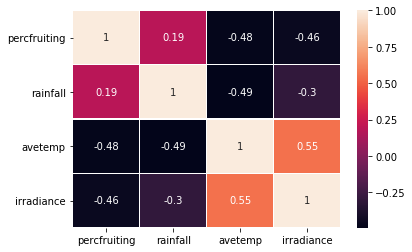

In [7]:
cormat = df_clean[['percfruiting','rainfall','avetemp','irradiance']].corr()
sns.heatmap(cormat, annot = True, linewidths = 0.5)

In [8]:
modelset = [m1,m2,m3,m4,m5,m6,m7,m8]

likelihoods = []
for model in modelset:
    ll = model.loglikelihood(X,Y)
    likelihoods.append(ll)
    
models = ['Full model','Rainfall, Temperature','Rainfall, Irradiance','Temperature, Irradiance','Rainfall','Temperature','Irradiance','Smooth terms only']

term_number = [8,7,7,7,6,6,6,5]

aicc = []
for l,n in zip(likelihoods, term_number):
    aic_score = -2*l + 2*n
    aicc_score = aic_score + (2*n) + (2*n*(n+1)/(178-n)) 
    aicc.append(aicc_score)

delta = []
for scores in aicc:
    delta.append(scores - min(aicc))

weights = []
weight_denominator_part1 = [x*-1/2 for x in delta]
weight_denominator_full = sum(np.exp(weight_denominator_part1))

for x in delta:
    weight = (np.exp(-1/2*x))/weight_denominator_full
    weights.append(weight)



In [9]:
len(m9.coef_)

23

In [10]:
summary_table = pd.DataFrame({'Parameters': models, 'LogLikelihood': likelihoods, 'Number_of_terms': term_number, 'AICc': aicc, 'delta AIC': delta, 'AIC weight': weights})
pd.set_option('display.expand_frame_repr', False)

print(summary_table)



                Parameters  LogLikelihood  Number_of_terms         AICc  delta AIC  AIC weight
0               Full model     570.512214                8 -1108.177369   8.393799    0.007611
1    Rainfall, Temperature     569.708333                7 -1110.761696   5.809472    0.027707
2     Rainfall, Irradiance     569.164540                7 -1109.674110   6.897058    0.016085
3  Temperature, Irradiance     570.416477                7 -1112.177983   4.393185    0.056252
4                 Rainfall     568.739043                6 -1112.989714   3.581454    0.084412
5              Temperature     569.704749                6 -1114.921125   1.650043    0.221720
6               Irradiance     568.688640                6 -1112.888907   3.682261    0.080263
7        Smooth terms only     568.458994                5 -1116.571168   0.000000    0.505950


In [11]:
#Constructing lists of all the partial dependencies of interannual and montly smooth functions across all 9 models

interannual = []
monthly = []
for n,m in enumerate(modelset):
    for i,term in enumerate(m.terms):
        if i == 0:
            interannual.append(m.partial_dependence(i)*weights[n])
        if i == 1:
            monthly.append(m.partial_dependence(i)*weights[n])



#Average each dependency value across models weighted by the AIC weights determined above
interannual_mean_dependencies = np.mean(interannual, axis = 0)
monthly_mean_dependencies = np.mean(monthly, axis = 0)

mean_d = pd.DataFrame()
mean_d['Interannual'] = list(interannual_mean_dependencies)
mean_d['Monthly'] = list(monthly_mean_dependencies)
print(mean_d)

    Interannual   Monthly
0     -0.120551 -0.026747
1     -0.110414 -0.029704
2     -0.100827 -0.032488
3     -0.091962 -0.035019
4     -0.083993 -0.037221
5     -0.077093 -0.039015
6     -0.071436 -0.040322
7     -0.067100 -0.041093
8     -0.063936 -0.041341
9     -0.061766 -0.041088
10    -0.060409 -0.040359
11    -0.059683 -0.039176
12    -0.059410 -0.037563
13    -0.059397 -0.035586
14    -0.059440 -0.033369
15    -0.059331 -0.031042
16    -0.058863 -0.028735
17    -0.057831 -0.026580
18    -0.056035 -0.024701
19    -0.053454 -0.023163
20    -0.050232 -0.021968
21    -0.046516 -0.021120
22    -0.042455 -0.020619
23    -0.038199 -0.020468
24    -0.033888 -0.020662
25    -0.029587 -0.021155
26    -0.025317 -0.021871
27    -0.021100 -0.022736
28    -0.016956 -0.023674
29    -0.012905 -0.024611
..          ...       ...
70     0.023186 -0.014298
71     0.022921 -0.012347
72     0.022420 -0.010580
73     0.021693 -0.009018
74     0.020756 -0.007680
75     0.019620 -0.006583
76     0.018

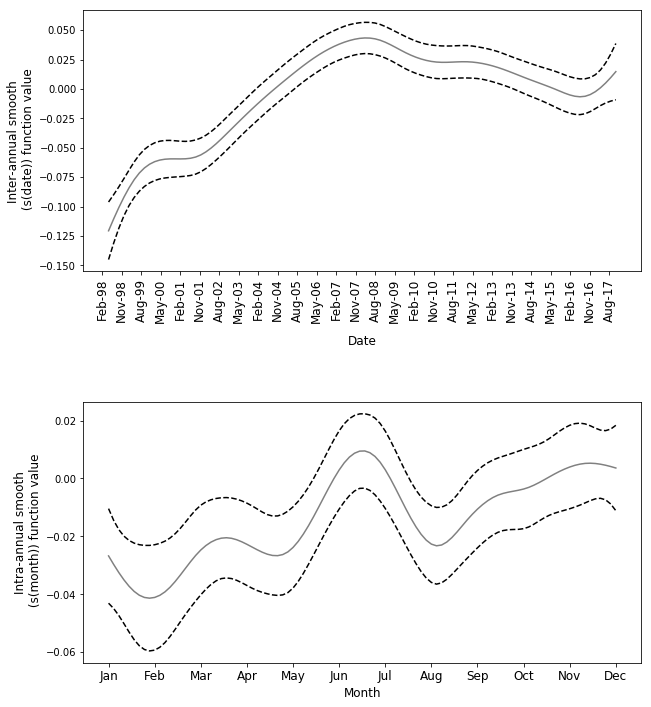

In [12]:
ia_coef = []
m_coef = []
ia_ci = []
m_ci = []

rain_coef = []
temp_coef = []
solar_coef = []
rain_ci = []
temp_ci = []
solar_ci = []

for n,m in enumerate(modelset):
    for i, term in enumerate(m.terms):
        if term.isintercept:
            continue 
        if i == 0 or i == 1:
            grid = m.generate_X_grid(term=i)
            coef, ci = m.partial_dependence(term=i, X=grid, width=0.95)
            if i == 0:
                ia_coef.append(coef*weights[n])
                ia_ci.append(ci*weights[n])
                ia_avg_coef = np.mean(ia_coef, axis = 0)
                ia_avg_ci = np.mean(ia_ci, axis = 0)

            if i == 1:
                m_coef.append(coef*weights[n])
                m_ci.append(ci*weights[n])
                m_avg_coef = np.mean(m_coef, axis = 0)            
                m_avg_ci = np.mean(m_ci, axis = 0)
                
            #Same thing for the linear predictors
            
        if i ==2 or i == 3 or i == 4:
            grid = m.generate_X_grid(term=i)
            coef, ci = m.partial_dependence(term=i, X=grid, width=0.95)
            if i == 2:
                rain_coef.append(coef*weights[n])
                rain_ci.append(ci*weights[n])
                rain_avg_coef = np.mean(rain_coef, axis = 0)
                rain_avg_ci = np.mean(rain_ci, axis = 0)

            if i == 3:
                temp_coef.append(coef*weights[n])
                temp_ci.append(ci*weights[n])
                temp_avg_coef = np.mean(temp_coef, axis = 0)            
                temp_avg_ci = np.mean(temp_ci, axis = 0)
            
            if i == 4: 
                solar_coef.append(coef*weights[n])
                solar_ci.append(ci*weights[n])
                solar_avg_coef = np.mean(solar_coef, axis = 0)            
                solar_avg_ci = np.mean(solar_ci, axis = 0)
                
                



plt.figure(figsize = (10, 12))

plt.subplot(2,1,1)
plt.plot(m1.generate_X_grid(term = 0)[:,0], ia_avg_coef, c='grey')
plt.plot(m1.generate_X_grid(term = 0)[:,0], ia_avg_ci, c='black', ls='--')
plt.xticks(np.arange(0,239, step = 9),df.date[::9], rotation = 90, fontsize = 'large')
plt.xlabel('Date', fontsize = 'large', labelpad = 12)
plt.ylabel('Inter-annual smooth\n (s(date)) function value', fontsize = 'large')
            
plt.subplot(2,1,2)
plt.plot(m1.generate_X_grid(term = 1)[:,1], m_avg_coef, c='grey')
plt.plot(m1.generate_X_grid(term = 1)[:,1], m_avg_ci, c='black', ls='--')
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], fontsize = 'large')
plt.xlabel('Month', fontsize = 'large')
plt.ylabel('Intra-annual smooth\n (s(month)) function value', fontsize = 'large')



plt.subplots_adjust(hspace = .5)
plt.show();

            

         
           
    

Text(0, 0.5, 'Proportion of trees with fruit')

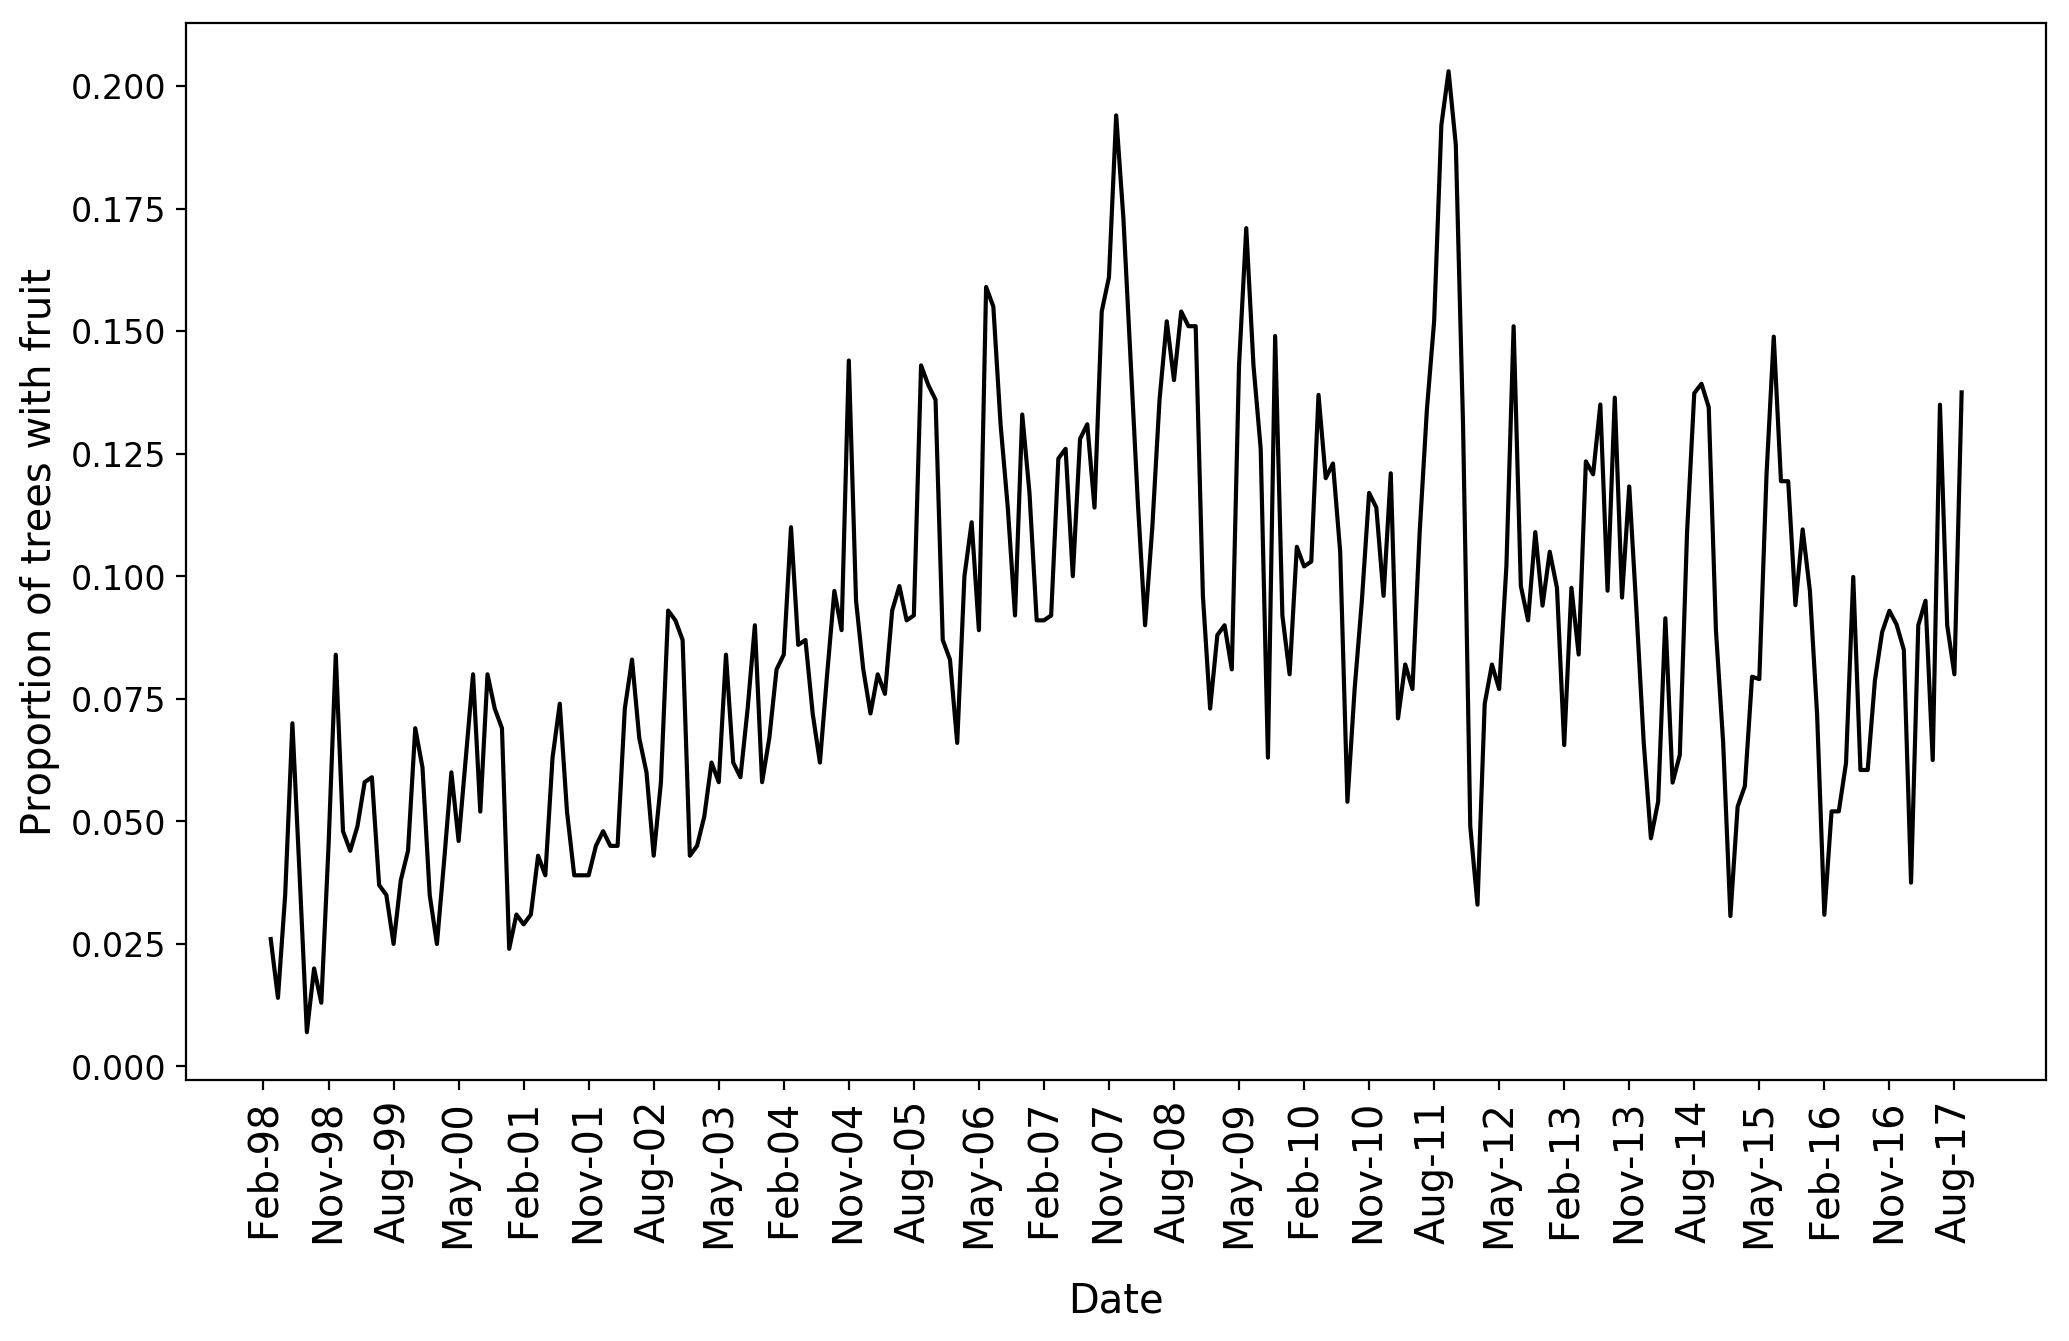

In [22]:
plt.figure(figsize = (12,7), dpi = 200)
plt.plot(df_clean.percfruiting, color = 'black', scalex = True)
plt.xticks(np.arange(0,239, step = 9),df.date[::9], rotation = 90, fontsize = 'x-large')
plt.yticks(fontsize = 'large')
plt.xlabel('Date', fontsize = 'x-large', labelpad = 12)
plt.ylabel('Proportion of trees with fruit', fontsize = 'x-large')

<Figure size 432x288 with 0 Axes>

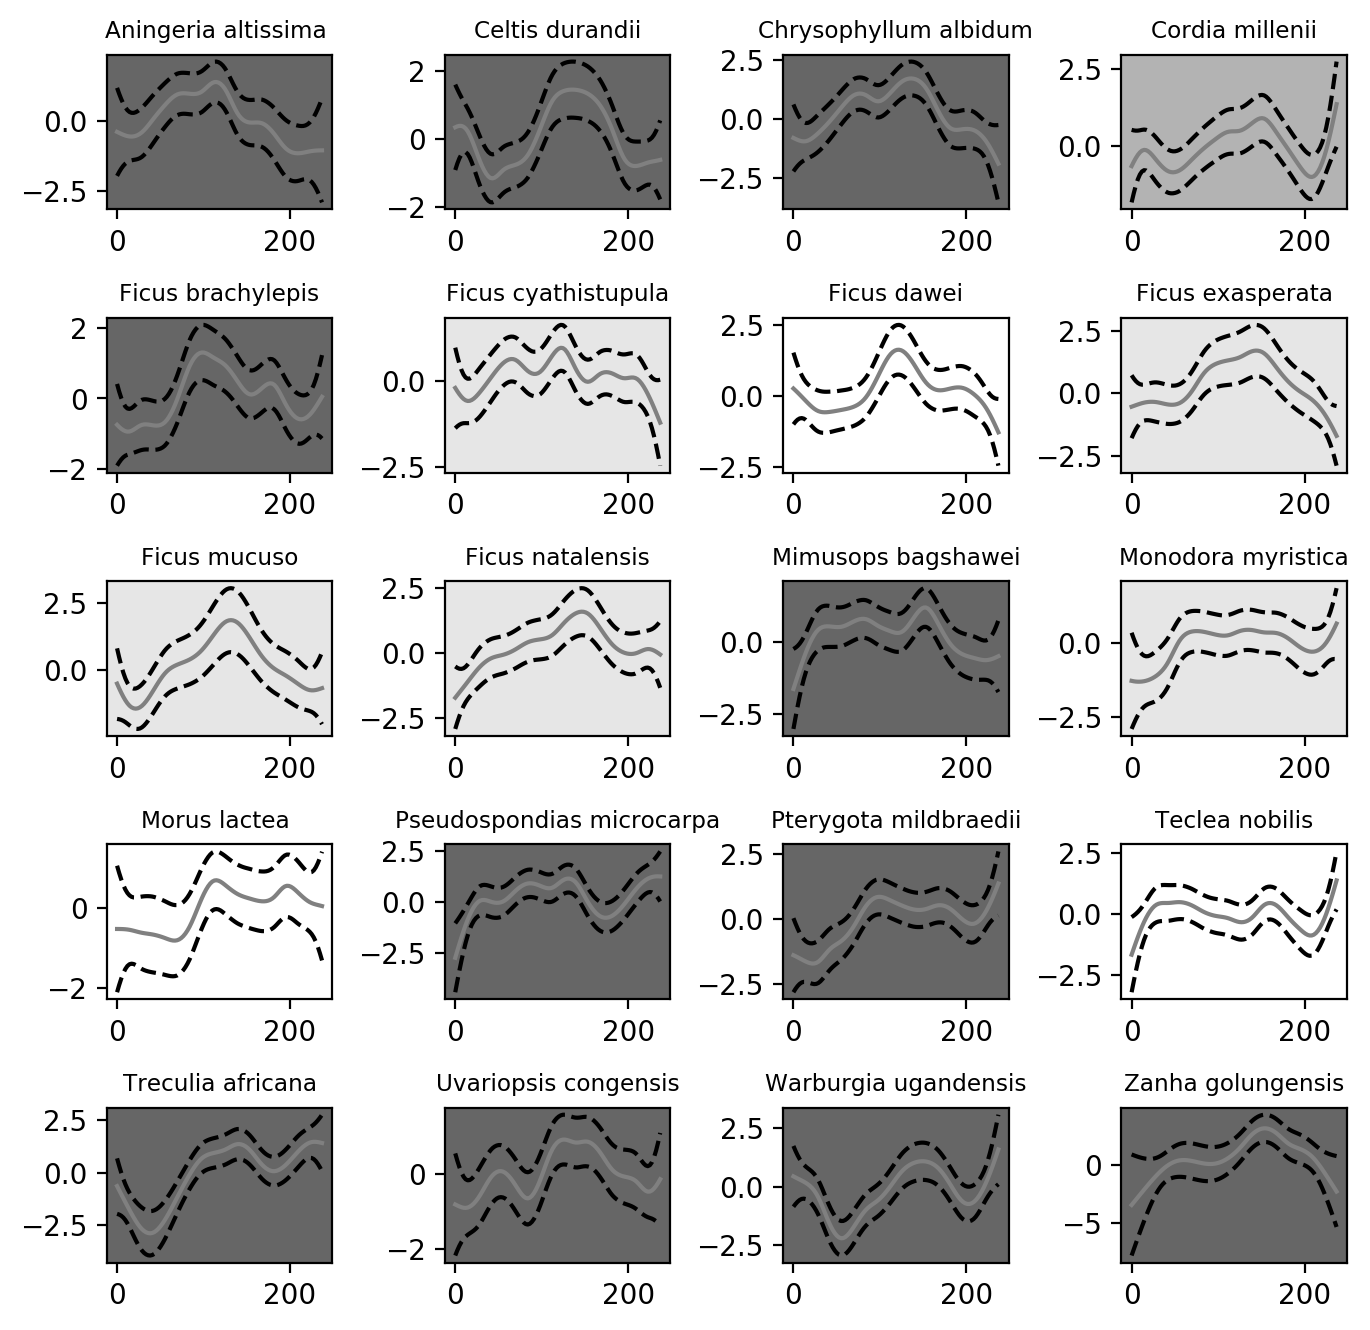

In [26]:
titles = sp_df.iloc[:, 2:22].columns.values

plt.figure();
plt.tight_layout;
fig, axs = plt.subplots(5,4, figsize = (8,8), dpi = 200);
plt.subplots_adjust(wspace = .5, hspace = .7)

pvals = []
llhoods = []

grids = []
pdeps = []
CIs = []



for x in range (0,20):
    sp_gam = GAM(s(0), distribution = 'binomial', link = 'logit').fit(sp_X,sp_Y.iloc[:, x])
    pvals.append(sp_gam.statistics_['p_values'][0])
    llhoods.append(sp_gam.statistics_['loglikelihood'])
    for i, term in enumerate(sp_gam.terms):
        if term.isintercept:
            continue
            
        XX = sp_gam.generate_X_grid(term=0)
        grids.append(XX)
        pdep, confi = sp_gam.partial_dependence(term=0, X=XX, width=0.95)
        pdeps.append(pdep)
        CIs.append(confi)
        
for i, ax in zip(range(0,20), np.ravel(axs)):
    ax.plot(grids[i][:, 0], pdeps[i], c='grey')
    ax.plot(grids[i][:, 0], CIs[i], c='black', ls='--')
    ax.set_title(titles[i], fontsize = 'small')
    if pvals[i] <= 0.001:
        ax.set_facecolor('0.4')
    elif pvals[i] <= 0.01:
        ax.set_facecolor('0.7')
    elif pvals[i] <= 0.05:
        ax.set_facecolor('0.9')

plt.show()


In [17]:
from scipy.stats.distributions import chi2
def likelihood_ratio(llmin, llmax):
    return(2*(llmax-llmin))

LLratios = []
pvalues = []

sp_month = pd.read_csv('SpeciesFruiting.csv')

sp_month_X = sp_month[['NumDate','Month']]
sp_month_Y = sp_month.drop(columns = ['date','NumDate', 'Month'], axis = 1)
Months = []
NoMonths = []

for i in range(0,20):
    sp_month_gam = GAM(s(0) + s(1), distribution = 'binomial', link = 'logit').fit(sp_month_X,sp_month_Y.iloc[:,i])
    sp_gam = GAM(s(0), distribution = 'binomial', link = 'logit').fit(sp_month_X,sp_month_Y.iloc[:,i])
    month_ll = sp_month_gam.loglikelihood(sp_month_X, sp_month_Y.iloc[:,i])
    NoMonth_ll = sp_gam.loglikelihood(sp_month_X, sp_month_Y.iloc[:,i])
    LR = likelihood_ratio(NoMonth_ll, month_ll)
    LLratios.append(LR)
    Months.append(month_ll)
    NoMonths.append(NoMonth_ll)
    p = chi2.sf(LR, 12)
    pvalues.append(p)


print(LLratios)
print(pvalues)


[73.20949466410593, 35.318001107302194, 7.214743343159114, 80.11546641479754, 22.21639951255355, 19.76963967995607, 39.690536180062054, 14.967812121583393, 20.898830444900085, 12.338966462376021, 35.20457010352743, 105.14869508840744, 65.20780326380199, 14.576682207191823, 114.7989654874142, 47.51743523008929, 34.869303186602224, 59.706236687623914, 40.2499089823134, 15.484428735881323]
[7.998799150201859e-11, 0.00041669147147894834, 0.8431021488583953, 3.92320966108538e-12, 0.03516486106388886, 0.0715710219505946, 8.092621237668266e-05, 0.2432014423214217, 0.051881693990711145, 0.4188550693140624, 0.0004344333386122591, 5.425294939855392e-17, 2.4954231447332734e-09, 0.26540633629256355, 6.697332510130076e-19, 3.791604666713567e-06, 0.0004912842374250349, 2.5534221290211123e-08, 6.535303617770158e-05, 0.2160069205841992]


In [18]:
LL_table = pd.DataFrame({'Species': titles, 'LogLikelihood w/month': Months, 'LogLikelihood w/o month': NoMonths, 'LRT': LLratios, 'P': pvalues})
pd.set_option('display.expand_frame_repr', False)

print(LL_table)

                      Species  LogLikelihood w/month  LogLikelihood w/o month         LRT             P
0        Aningeria altissima              -76.406023              -113.010770   73.209495  7.998799e-11
1             Celtis durandii            -117.828717              -135.487718   35.318001  4.166915e-04
2       Chrysophyllum albidum            -133.164809              -136.772180    7.214743  8.431021e-01
3             Cordia millenii            -100.073497              -140.131230   80.115466  3.923210e-12
4           Ficus brachylepis            -128.651386              -139.759586   22.216400  3.516486e-02
5         Ficus cyathistupula            -145.931035              -155.815855   19.769640  7.157102e-02
6                 Ficus dawei            -110.247017              -130.092285   39.690536  8.092621e-05
7            Ficus exasperata             -93.922744              -101.406650   14.967812  2.432014e-01
8                Ficus mucuso             -78.459030            